## Project - Triangular mesh generator

## A Project From Class- Individual Work

First we include some libraries and define utility functions from the lecture notes:

In [1]:
using PyPlot, LinearAlgebra, PyCall

function tplot(p, t)
    # Plot triangular mesh with nodes `p` and triangles `t`
    tris = convert(Array{Int64}, hcat(t...)')
    tripcolor(first.(p), last.(p), tris .- 1, 0*tris[:,1],
              cmap="Set3", edgecolors="k", linewidth=1)
    axis("equal")
    return
end

function delaunay(p)
    # Delaunay triangulation `t` of array of nodes `p`
    tri = pyimport("matplotlib.tri")
    t = tri[:Triangulation](first.(p), last.(p))
    t = Int64.(t[:triangles] .+ 1)
    t = [ t[i,:] for i = 1:size(t,1) ]
end

delaunay (generic function with 1 method)

### Description

In this project you will write an unstructured triangular mesh generator based on the Delaunay refinement algorithm. The steps will be described in detail, and for testing we will use the following simple polygon:

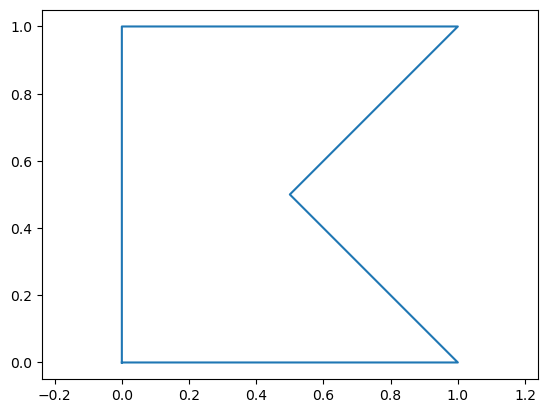

In [2]:
pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
plot(first.(pv), last.(pv))
axis("equal");

### Point in polygon

Write a function `inpolygon(p, pv)` which determines if a point `p` is inside the closed polygon `pv`.

In [3]:
function inpolygon(p ,pv)
    x = p[1]
    y = p[2]
    inside = false
    k = 1:(length(pv)-1)
    l = [length(pv)]
    num = 0
    for i = 1:(length(pv)-1)
        j = i+1
        xi = pv[i][1]
        yi = pv[i][2]
        xj = pv[j][1]
        yj = pv[j][2]
        if ((yi > y) != (yj > y)) && x < ((((xj - xi) * (y - yi)) / (yj - yi)) + xi)
             num += 1
        end
    end
    if num%2 == 1
        inside = true
        end
    return inside
end

inpolygon (generic function with 1 method)

### Triangle properties

Next we need functions for computing some basic quantities from triangles. Here, a triangle `tri` is represented as an array of 3 points, e.g.

In [4]:
tri = [[1,0.5], [2,1], [0,3]]

3-element Vector{Vector{Float64}}:
 [1.0, 0.5]
 [2.0, 1.0]
 [0.0, 3.0]

### Triangle area

Function `tri_area(tri)` which returns the area of `tri`.

In [5]:
function tri_area(tri)
    ax = tri[1][1] 
    bx = tri[2][1] 
    cx = tri[3][1] 
    ay = tri[1][2] 
    by = tri[2][2] 
    cy = tri[3][2] 
    area = abs(ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))/2
    return area
end
    

tri_area (generic function with 1 method)

###Triangle centroid

Function `tri_centroid(tri)` which returns the centroid of `tri` (<https://en.wikipedia.org/wiki/Centroid#Of_a_triangle>).

In [6]:
function tri_centroid(tri)
    x = [tri[i][1] for i = 1:length(tri)]
    y = [tri[i][2] for i = 1:length(tri)]
    cx = sum(x)./3
    cy = sum(y)./3
    return [cx,cy]
end
    

tri_centroid (generic function with 1 method)

### Triangle circumcenter

Function `tri_circumcenter(tri)` which returns the circumcenter of `tri` (<https://en.wikipedia.org/wiki/Circumscribed_circle#Cartesian_coordinates_2>).

In [7]:
function tri_circumcenter(tri)
    ax = tri[1][1] 
    bx = tri[2][1] 
    cx = tri[3][1] 
    ay = tri[1][2] 
    by = tri[2][2] 
    cy = tri[3][2] 
    
    D = 2 * (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
    
    ux = (1/D) * ((ax^2 + ay^2)*(by - cy) + (bx^2 + by^2)*(cy - ay) + (cx^2 + cy^2)*(ay - by))
    uy = (1/D) * ((ax^2 + ay^2)*(cx - bx) + (bx^2 + by^2)*(ax - cx) + (cx^2 + cy^2)*(bx - ax))
    
    return [ux, uy]
    
end


tri_circumcenter (generic function with 1 method)

### Mesh generator
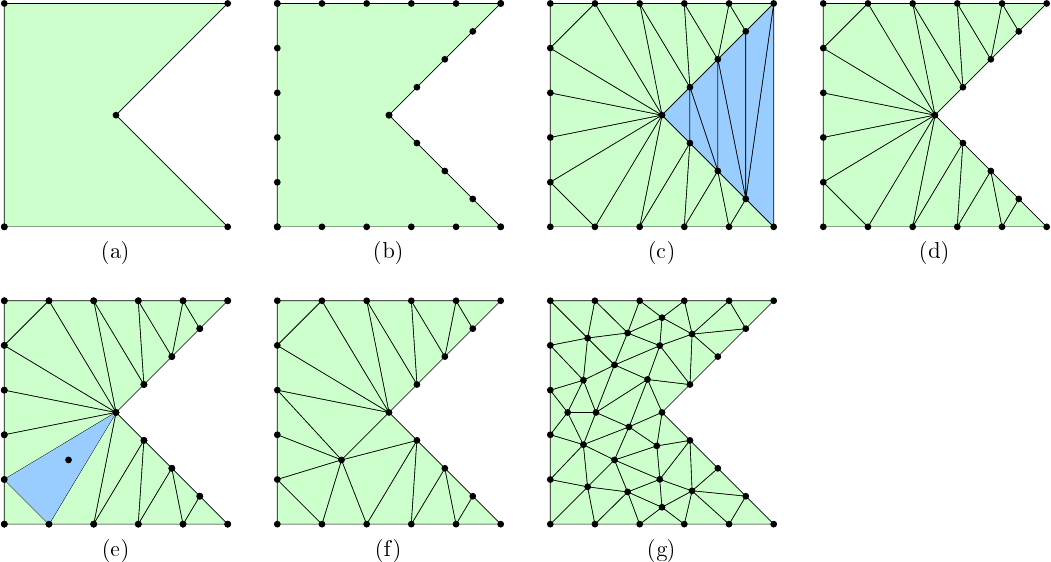

In [8]:
function pmesh(pv, hmax)
    p = []
    t = []
    get_the_coordinates(x) = [p[j] for j in x]
    for i = 1:length(pv)-1
        x = pv[i][1]
        y = pv[i][2]
        x_now = pv[i][1]
        y_now = pv[i][2]
        x_next = pv[i+1][1]
        y_next = pv[i+1][2]
        push!(p, [x,y])
        points_to_add = ceil(((x_next - x_now)^2 + (y_next - y_now)^2)^0.5/hmax)
        for j =1:points_to_add - 1
            x += (x_next - x_now)/points_to_add
            y += (y_next - y_now)/points_to_add
            push!(p, [x,y])
        end
    end
    tolerated_area = (hmax^2)/2
    bellow_max = false
    t = delaunay(p)
    #iter = 1
    
    while !bellow_max #&& iter < 3
        #println(iter)
        t = delaunay(p)
        triangles_inside = []
        for i in t
            triangle = get_the_coordinates(i)
            centroid = tri_centroid(triangle)
            if inpolygon(centroid, pv)
                push!(triangles_inside, i)
            end
        end
        t = triangles_inside
        area_max = 0
        biggest_triangle = []
        for i in t
            triangle = get_the_coordinates(i)
            triangle_area = tri_area(triangle)
            if triangle_area > area_max
                area_max = triangle_area
                biggest_triangle = triangle
            end
        end
        if area_max > tolerated_area
            push!(p, tri_circumcenter(biggest_triangle))
        else
            bellow_max = true
        end
       # iter += 1;
        #t = delaunay(p)
    end
    return p,t
end


pmesh (generic function with 1 method)

### Test cases

Run the cases below to test your mesh generator.

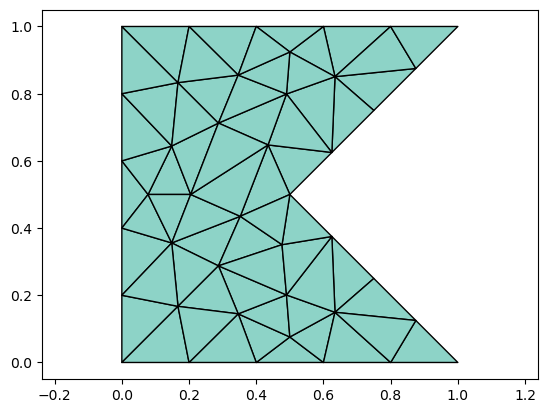

In [9]:
# The polygon in the examples
pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
p,t = pmesh(pv, 0.2)
tplot(p,t)

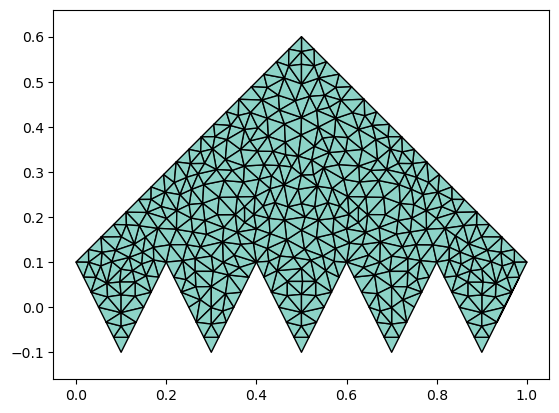

In [10]:
# A more complex shape
pv = [[i/10,0.1*(-1)^i] for i = 0:10]
append!(pv, [[.5,.6], [0,.1]])
p,t = pmesh(pv, 0.04)
tplot(p,t)